### Sentiment Analysis using Python 
#### Dataset :  Beauty Product Reviews from Amazon

- Import required libraries listed in the below kernel
- You can install the libraries using 
- - pip install <library_name> 
- - python -m pip install <library_name> 

In [20]:
# Import Libraries 
#nltk and related branches
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re
import json
import boto3
import datetime
import pandas as pd
import numpy as np
import text2emotion as te
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS


In [19]:
import warnings
warnings.filterwarnings('ignore')

- Use the following script in case below nltk.download fails
- - nltk.download('punkt')
- - nltk.download('stopwords')

***********************************************************************
* import nltk
* import ssl

* try:
*   _create_unverified_https_context = ssl._create_unverified_context
* except AttributeError:
*    pass
* else:
*    ssl._create_default_https_context = _create_unverified_https_context

* nltk.download()
************************************************************************

#### Read data from AWS S3 Bucket

In [6]:
def read_json(bucket, filename, credentials):
    import boto3
    import json
    import pandas as pd

    creds = json.load(open(credentials))
    s3 = boto3.client(
        's3',
        aws_access_key_id = creds['key'],
        aws_secret_access_key = creds['secret'],

    )

    result = s3.get_object(Bucket = bucket, Key = filename) 
    text = result["Body"].read().decode('utf-8')
    json_list = text.strip().split('\n')
    data_dict =[]
    # Process each JSON string
    for json_str in json_list:
        data_dict.append(json.loads(json_str))
    
    json_content_df = pd.DataFrame(data_dict)
    return json_content_df

In [7]:
#Calling the above function - result is obtained in the form of a pandas df
# Bucket name = 'thoughtspot-snowpark'
# File names - 'All_Beauty.json', 'meta_All_Beauty.json'
all_beauty_df = read_json("thoughtspot-snowpark", 'All_Beauty.json','credentials.json')
meta_all_beauty_df = read_json("thoughtspot-snowpark", 'meta_All_Beauty.json','credentials.json')


#### Functions to perform analysis on the data

In [8]:
# Define a function to clean the text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

analyzer = SentimentIntensityAnalyzer()
# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'
    
# Function to find the matching keyword in the title
def find_matching_keyword(title, keywords):
    if pd.notna(title) and isinstance(title, str):
        title_lower = title.lower()  # Convert title to lowercase for case-insensitive matching
        for keyword in keywords:
            if pd.notna(keyword):
                keyword_words = keyword.lower().split()
                if any(word in title_lower for word in keyword_words):
                    return keyword
    return 'Others'

#### Data cleaning and merging 

In [9]:
# Convert "reviewTime" column to datetime
try:
    time_col = list(filter(lambda col: 'time' in col.lower(), all_beauty_df.columns))[0]
except:
    raise Exception('No time column present / check if time column is present in the data')

all_beauty_df["reviewTime"] = pd.to_datetime(all_beauty_df[time_col], format="%m %d, %Y")

# Extract the date and year components and combine them into a new column
all_beauty_df["Date"] = all_beauty_df["reviewTime"].dt.date
all_beauty_df["Year"] = all_beauty_df["reviewTime"].dt.year

# Drop the original "reviewTime" column
all_beauty_df.drop("reviewTime", axis=1, inplace=True)

#merging two datasets
merged_df = pd.merge(all_beauty_df[['overall',"Date","Year", "reviewText","asin"]], meta_all_beauty_df[["title" ,"asin","brand"]], on="asin", how="inner")
df_cleaned = merged_df.drop_duplicates('reviewText', keep=False)

# Drop rows where the "title" column is null
no_duplicates_df = df_cleaned[df_cleaned['title'] != '']
no_duplicates_df = df_cleaned[df_cleaned['brand'] != '']

# Cleaning the text in the review column
no_duplicates_df['Cleaned Reviews'] = no_duplicates_df['reviewText'].apply(clean)
no_duplicates_df = no_duplicates_df.reset_index()
no_duplicates_df.head()


,index,overall,Date,Year,reviewText,asin,title,brand,Cleaned Reviews
0,0,5.0,2016-03-10,2016,Excellent very good,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,Pirmal Healthcare,Excellent very good
1,2,5.0,2014-10-03,2014,Magical,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,Pirmal Healthcare,Magical
2,4,4.0,2014-06-14,2014,I do like the product a lot...I had bought the...,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,Pirmal Healthcare,I do like the product a lot I had bought them ...
3,5,5.0,2018-03-02,2018,I have OILY skin. I have tried quite a few mat...,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,Pirmal Healthcare,I have OILY skin I have tried quite a few matt...
4,6,1.0,2017-10-05,2017,Got different bottle looks dulpicate,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,Pirmal Healthcare,Got different bottle looks dulpicate


#### Calculating Vader sentiment score and sentiment - positive, negative and neutral

In [10]:
no_duplicates_df['Vader Sentiment'] = no_duplicates_df['reviewText'].apply(vadersentimentanalysis)
no_duplicates_df['Vader Analysis'] = no_duplicates_df['Vader Sentiment'].apply(vader_analysis)

#### Emotion detection using Text2emotion

- In  case  of  error  -  go  to  **/Users/.../python<version>/site-packages/text2emotion/__init__.py** ,
- at  line  2700  -  **'text = emojis_extractor(text)'**  -  add  '**#**'  at  the  beginning  of  the  line  and  save  the  file.
- Restart  **VSCODE / kernel**  ->  import  libraries  again.


In [11]:
emot_data = no_duplicates_df.drop(['asin'],axis=1)
emot_data["Year"] = emot_data["Year"].astype('int')
emotion_df=pd.DataFrame.from_records(emot_data.loc[:1000].apply(lambda row: te.get_emotion(row['Cleaned Reviews']),axis=1))
emotion_df_merge = pd.merge(emot_data.loc[:1000], emotion_df, left_index=True, right_index=True)
emotion_df_merge['emotion'] = emotion_df_merge[['Happy', 'Angry','Surprise', 'Sad', 'Fear']].idxmax(axis=1)
emotion_df_merge.head(2)

,index,overall,Date,Year,reviewText,title,brand,Cleaned Reviews,Vader Sentiment,Vader Analysis,Happy,Angry,Surprise,Sad,Fear,emotion
0,0,5.0,2016-03-10,2016,Excellent very good,Lacto Calamine Skin Balance Oil control 120 ml...,Pirmal Healthcare,Excellent very good,0.7841,Positive,1.0,0.0,0.0,0.0,0.0,Happy
1,2,5.0,2014-10-03,2014,Magical,Lacto Calamine Skin Balance Oil control 120 ml...,Pirmal Healthcare,Magical,0.0000,Neutral,0.0,0.0,0.0,0.0,0.0,Happy


#### Category based analysis

- The data lacks a category column, so we've generated one using the product title by mapping products to common beauty product categories in the industry.

In [13]:
eg = no_duplicates_df[['title']].drop_duplicates()
eg.reset_index().drop('index',axis=1).head(4)

,title
0,Lacto Calamine Skin Balance Oil control 120 ml...
1,Mary Kay Satin Hands Hand Cream Travel MINI Si...
2,Jenna Jameson Heartbreaker Perfume for women 3...
3,Wilkinson Sword Double Edge Razor Blade Refill...


In [14]:
#Importing Keywords
Keywords_df = pd.read_csv("Keywords_extraction.csv")

#Mapping each product to a category
no_duplicates_df['Category'] = no_duplicates_df.apply(lambda row: find_matching_keyword(row['title'], Keywords_df['keywords']), axis=1)

# List of columns to extract
columns_to_extract = ["Date", "Category", "Vader Analysis", "Vader Sentiment"]

# Create a new DataFrame with the selected columns
category_time = no_duplicates_df[columns_to_extract].copy()
category_time.reset_index(drop=True, inplace=True)

# Use the value_counts() function to get the counts for each category in the 'Category' column
value_counts = category_time['Category'].value_counts()

# Filter the DataFrame to keep only the rows where the value count is greater than 10000
selected_categories = value_counts.nlargest(10).index

# Select only the columns where the 'Category' column matches the selected categories
category_time = category_time[category_time['Category'].isin(selected_categories)]

# Display the new table
category_time.head()

,Date,Category,Vader Analysis,Vader Sentiment
0,2016-03-10,Skin care,Positive,0.7841
1,2014-10-03,Skin care,Neutral,0.0000
2,2014-06-14,Skin care,Neutral,-0.2182
3,2018-03-02,Skin care,Positive,0.8605
4,2017-10-05,Skin care,Neutral,0.0000


#### Recommendation

In [15]:
# Step 1: Calculate the maximum 'Vader Sentiment' score for each group of 'title' and 'brand'
mean_scores = no_duplicates_df.groupby(['title', 'brand'])['Vader Sentiment'].median()

# Step 2: Create a new DataFrame to store the results
result_df = no_duplicates_df.copy()

# Step 3: Merge the calculated max_scores into the result_df based on the 'title' and 'brand' columns
result_df = result_df.merge(mean_scores.rename('median_score'), left_on=['title', 'brand'], right_index=True)

# Step 4: Assign the "Recommendation" based on the 'median_score' column
result_df['Recommendation'] = result_df['median_score'].apply(lambda score: 'Recommended' if score > 0.75 else 'Not Recommended')

In [16]:
result_df.head(2)

,index,overall,Date,Year,reviewText,asin,title,brand,Cleaned Reviews,Vader Sentiment,Vader Analysis,Category,median_score,Recommendation
0,0,5.0,2016-03-10,2016,Excellent very good,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,Pirmal Healthcare,Excellent very good,0.7841,Positive,Skin care,0.7184,Not Recommended
1,2,5.0,2014-10-03,2014,Magical,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,Pirmal Healthcare,Magical,0.0000,Neutral,Skin care,0.7184,Not Recommended


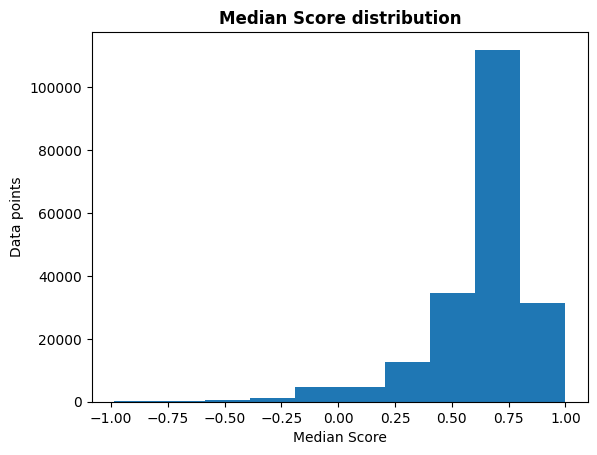

In [17]:
# Display the result_df 
plt.xlabel('Median Score')
plt.ylabel('Data points')
plt.title('Median Score distribution',
          fontweight = "bold")
plt.hist(result_df['median_score'])
plt.show()


#### Writing data to csv files

In [18]:
no_duplicates_df.to_csv('cleaned_data/beauty_product_reviews.csv',index=False)
emotion_df.to_csv('cleaned_data/emotions_overall.csv',index=False)
emotion_df_merge.to_csv('cleaned_data/emotions.csv',index=False)
category_time.to_csv('cleaned_data/category_analysis.csv',index=False)
columns_to_extract = ['brand', 'title', 'Category', 'median_score', 'Recommendation']
recommendation_table = result_df[columns_to_extract]
recommendation_table.to_csv('cleaned_data/recommendations.csv',index=False)
columns_to_extract = ['Date', 'reviewText', 'title', 'brand', 'Vader Sentiment', 'Vader Analysis', 'Category']
st_tl_table=no_duplicates_df[columns_to_extract]
st_tl_table.to_csv('cleaned_data/sentiment_trends.csv',index=False)